In [1]:
import tensorflow as tf
import numpy as np
import os
import shutil
import random
import glob
import cv2
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re
import string
from sklearn.model_selection import train_test_split

tfk = tf.keras
tfkl = tf.keras.layers
kb = tf.keras.backend
print(tf.__version__)

2023-02-01 17:56:31.315249: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-01 17:56:32.160412: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/riga/anaconda3/envs/tf-gpu/lib/
2023-02-01 17:56:32.160487: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/riga/anaconda3/envs/tf-gpu/lib/
2023-02-01 17:56:32.160495: W tensorflow/compiler/tf2t

2.11.0


In [2]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [3]:
image_dir = "./resized_train"
caption_pred_file = "caption_prediction_train.csv"
concept_pred_file = "concept_prediction_train.csv"
concept_file = "concepts.csv"

In [4]:
concepts = pd.read_csv(concept_file, sep='\t')
concepts = concepts.set_index('concept')['concept_name'].to_dict()

captions = pd.read_csv(caption_pred_file, sep='\t')
captions = captions.set_index('ID')['caption'].to_dict()

In [5]:
# Define a list of characters to strip from input text
strip_chars = string.punctuation + "¿"

# Remove "[" and "]" from the list of stripped characters
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    # convert input string to lowercase
    lowercase = tf.strings.lower(input_string)
    # replace special characters with empty string
    return tf.strings.regex_replace(lowercase, "[%s]" % re.escape(strip_chars), "")

In [6]:
result = ""
for i in captions.values():
    result += " " + i
result = custom_standardization(result)
result = bytes.decode(result.numpy())
print("Vocab size:")
print(len(set(result.split())))

longest = max(captions.values(), key=len)
longest = custom_standardization(longest)
longest = bytes.decode(longest.numpy())
longest = longest.split()
print("Longest sequence:")
print(len(longest))

2023-02-01 17:56:34.253576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 17:56:34.272083: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 17:56:34.272328: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-02-01 17:56:34.272819: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorF

Vocab size:
35489
Longest sequence:
391


In [7]:
def load_data(limit=0):
    images = []
    _max = 0
    
    files = [filename for filename in os.listdir(image_dir)]
    if limit != 0:
        files = random.sample(files, limit)
        
    for filename in files:
        name = os.path.splitext(filename)[0]
        if name not in captions:
            continue

        image_path = os.path.join(image_dir, name + ".jpg")
        image = cv2.imread(image_path)

        # Preprocess images
        image = np.array(image)
        image = image.astype('float32')
        image /= 255 
        
        # Preprocess texts
        text = captions[name]
        text = "[SOS] " + text + " [EOS]"
        text = text_vectorization(captions[name])
        
        images.append((image, text))
            
    return images

def load_dataset(limit=0, test=0.2, val=0.0):
    image_pairs = load_data(limit)
    
    random.shuffle(image_pairs)
    num_test_samples = int(test * len(image_pairs))
    num_val_samples = int(val * len(image_pairs))
    test_pairs = image_pairs[:num_test_samples]
    val_pairs = image_pairs[num_test_samples : num_test_samples + num_val_samples]
    train_pairs = image_pairs[num_test_samples + num_val_samples :]
    
    return train_pairs, val_pairs, test_pairs

def visualize_dataset(dataset, nums=5):
    for n, (i, t) in enumerate(random.sample(dataset, nums)):
        plt.figure(figsize=(50, 100))
        plt.subplot(nums, 1, n + 1)
        plt.imshow(i)
        plt.title(f"{t}", fontsize=100)
        plt.xticks([])
        plt.yticks([])

In [8]:
vocab_size = 35491
sequence_length = 393

text_vectorization = tfkl.TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=custom_standardization,
)

train_captions = [v for v in captions.values()]
text_vectorization.adapt(train_captions)

In [9]:
ds_train, ds_val, ds_test = load_dataset(100, test=0.2, val=0.2)

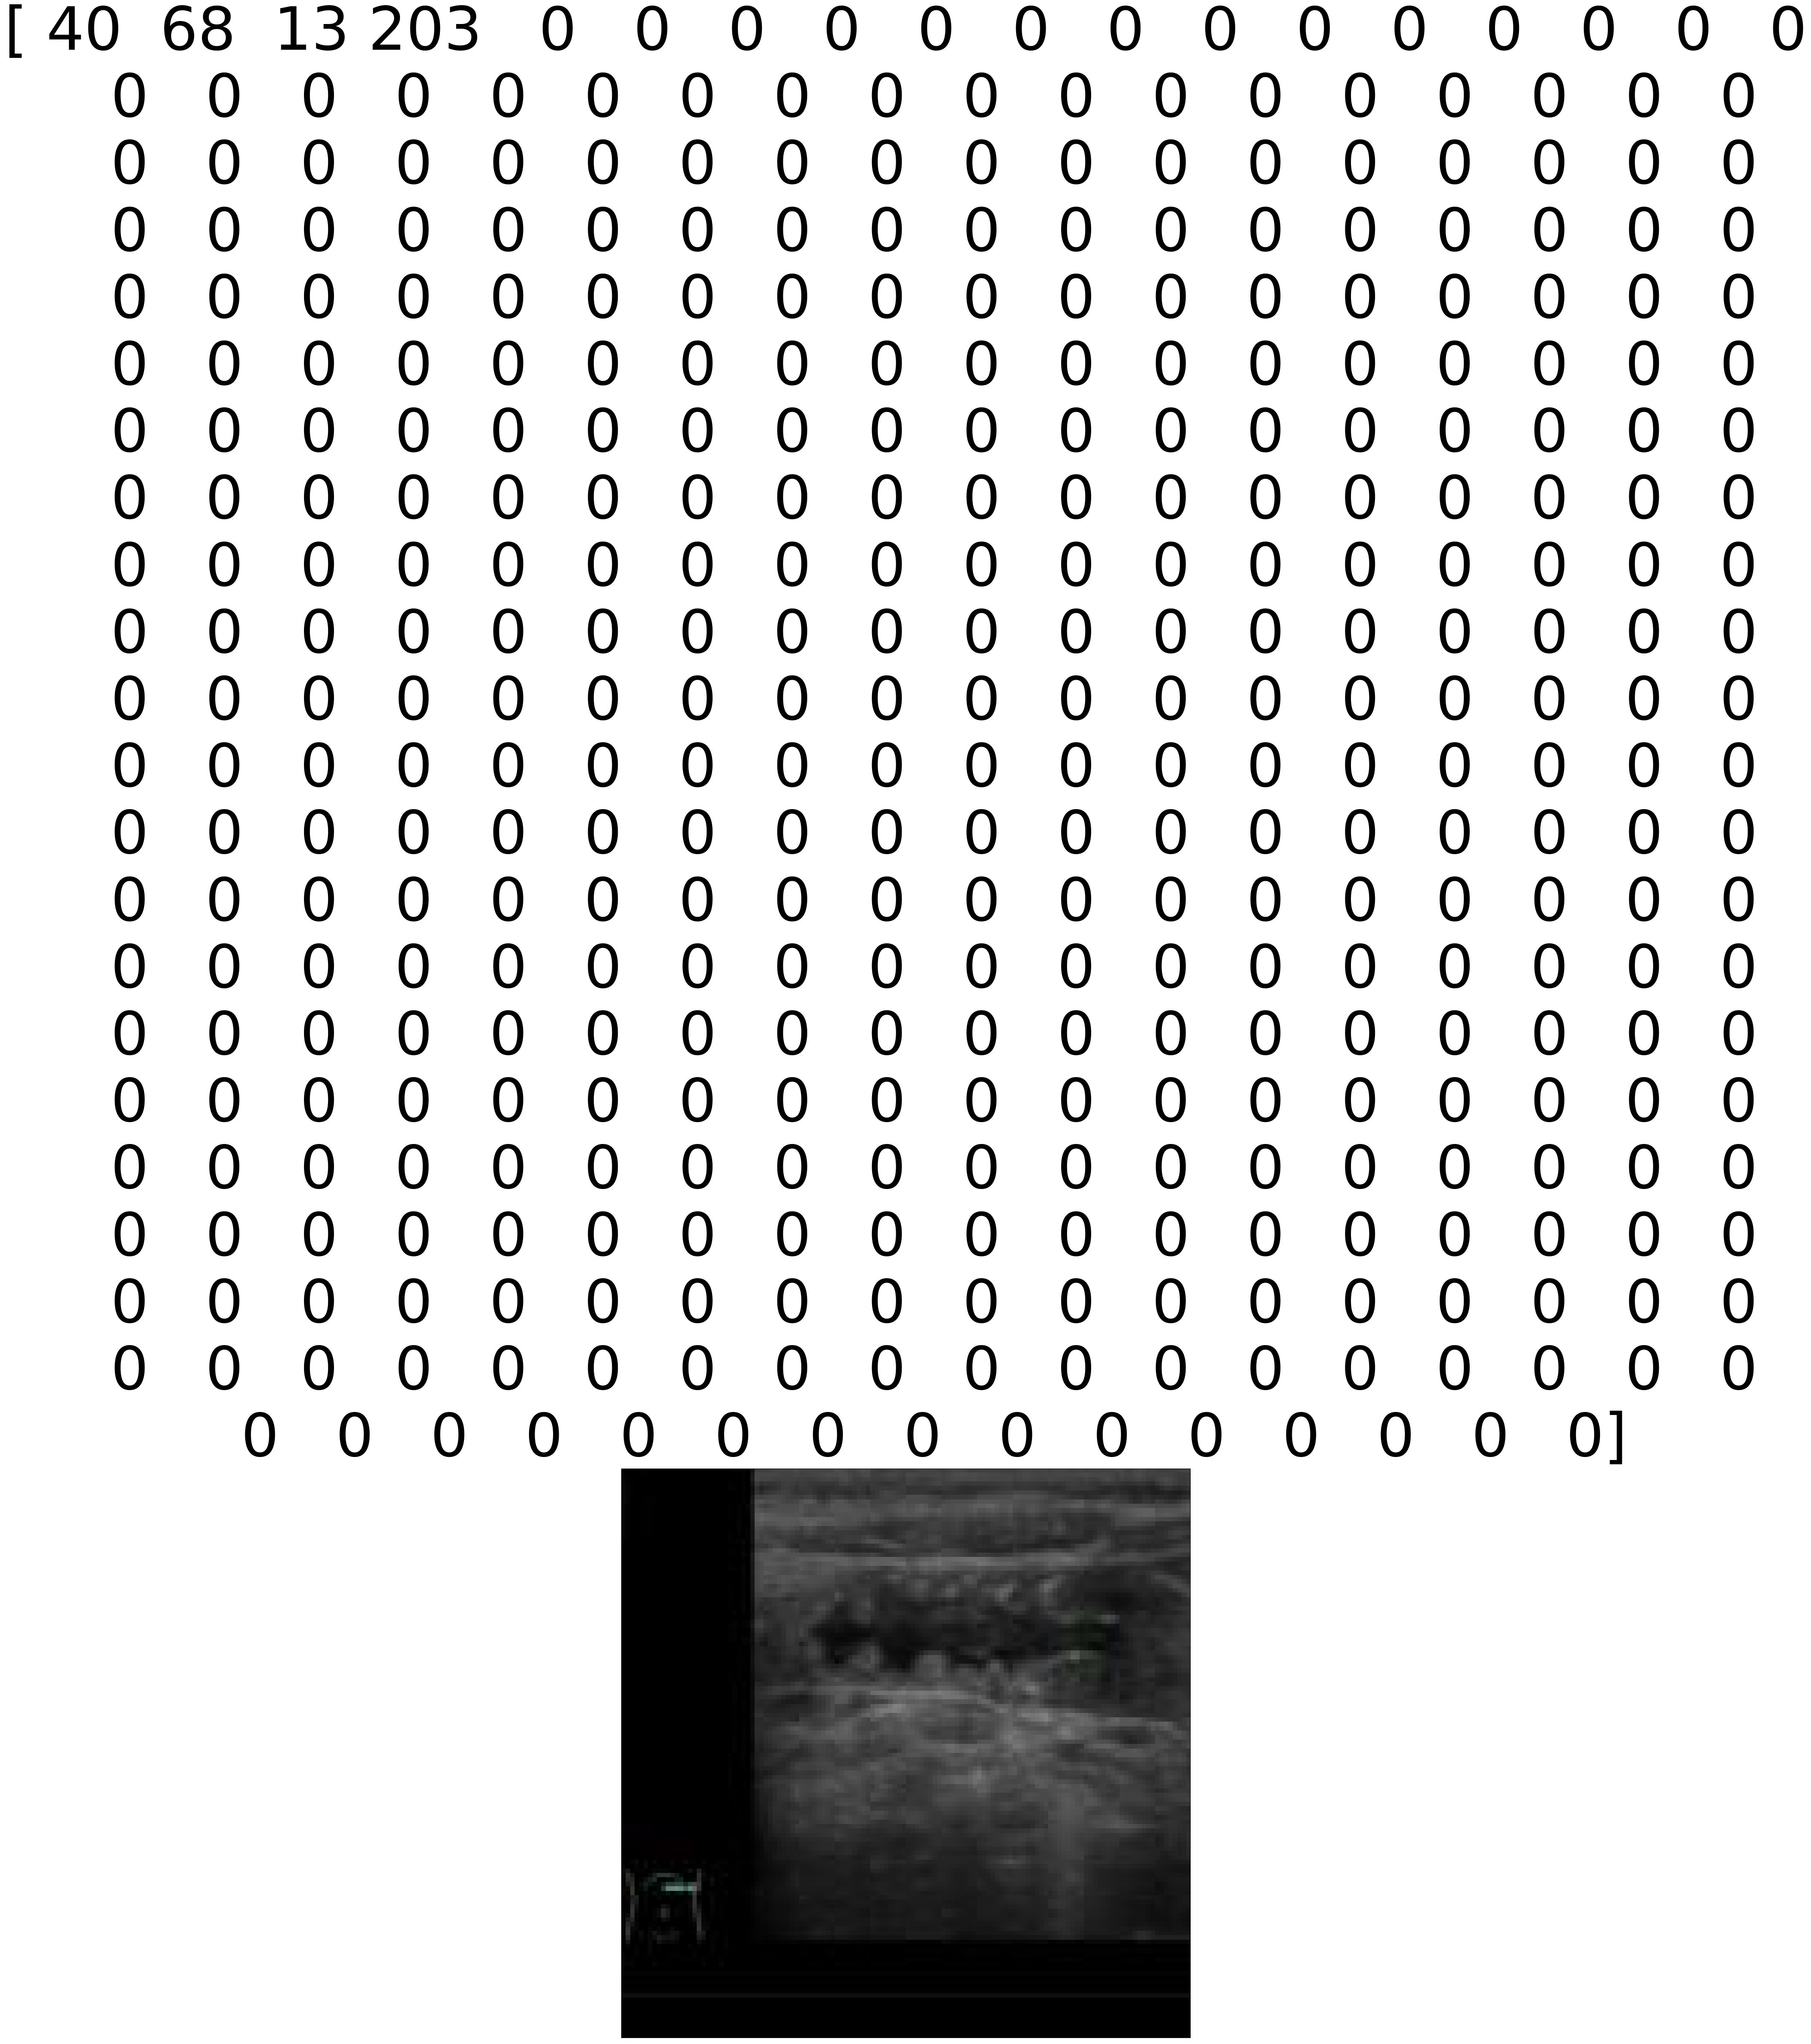

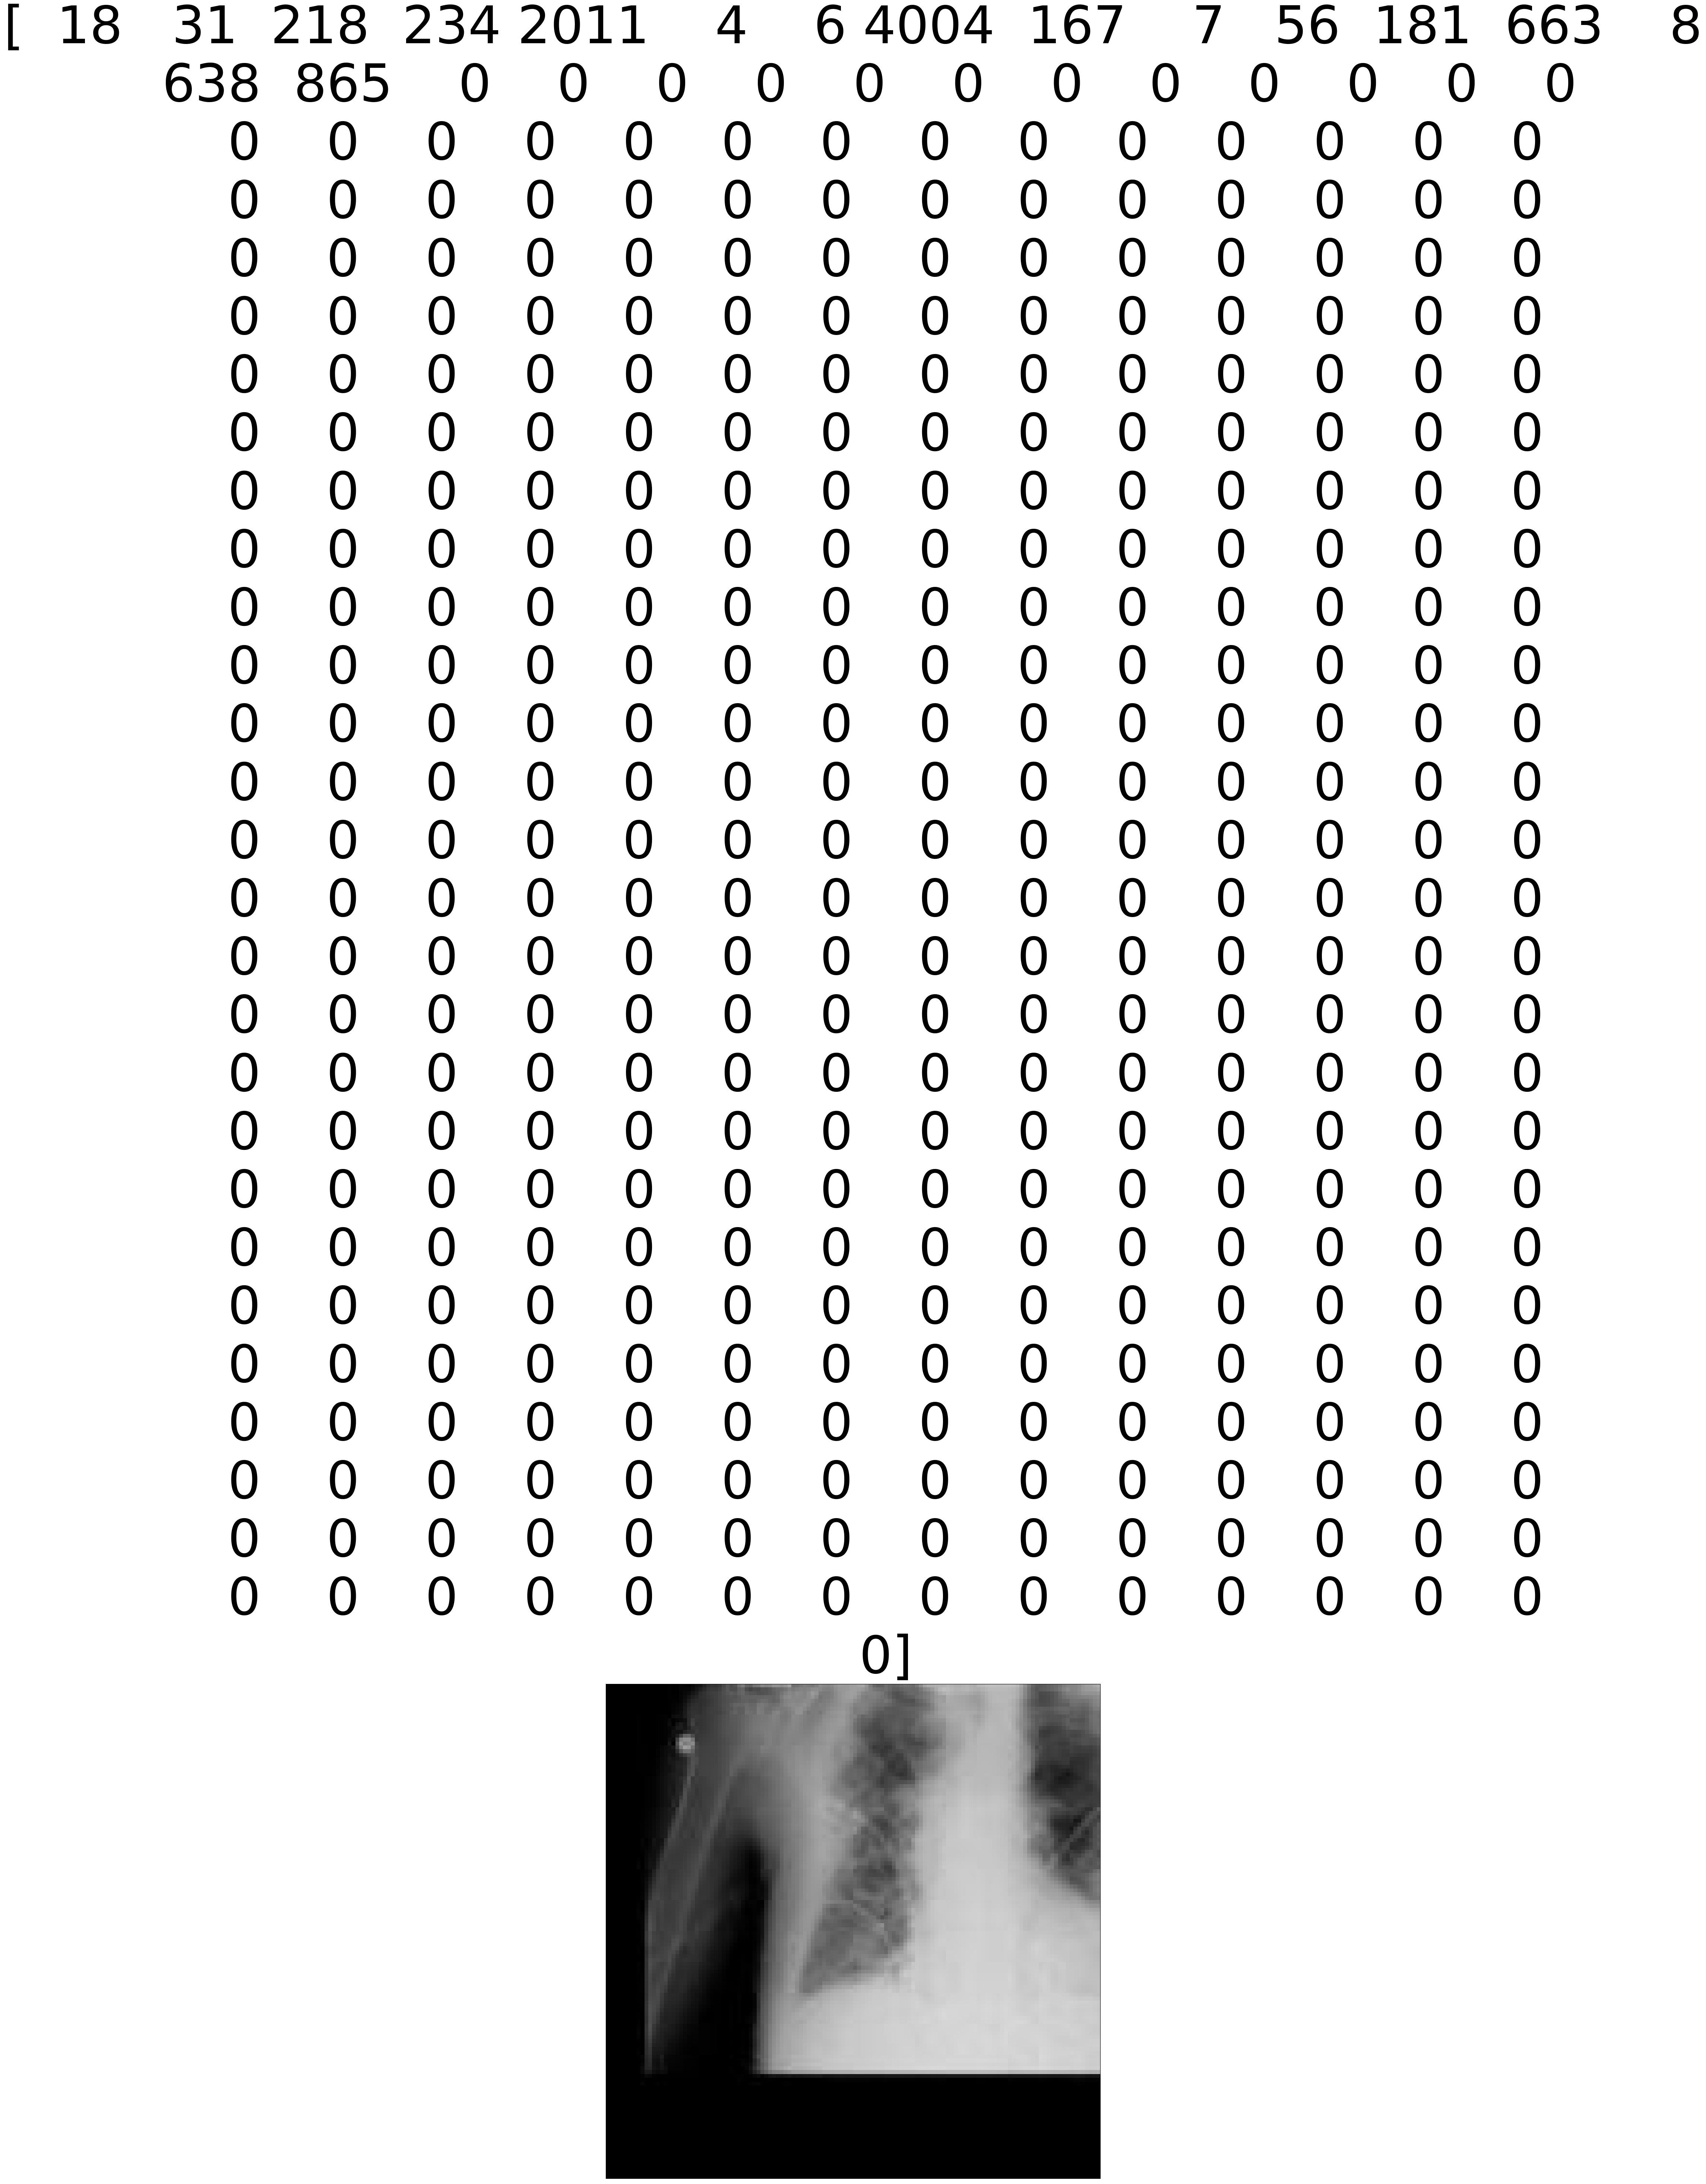

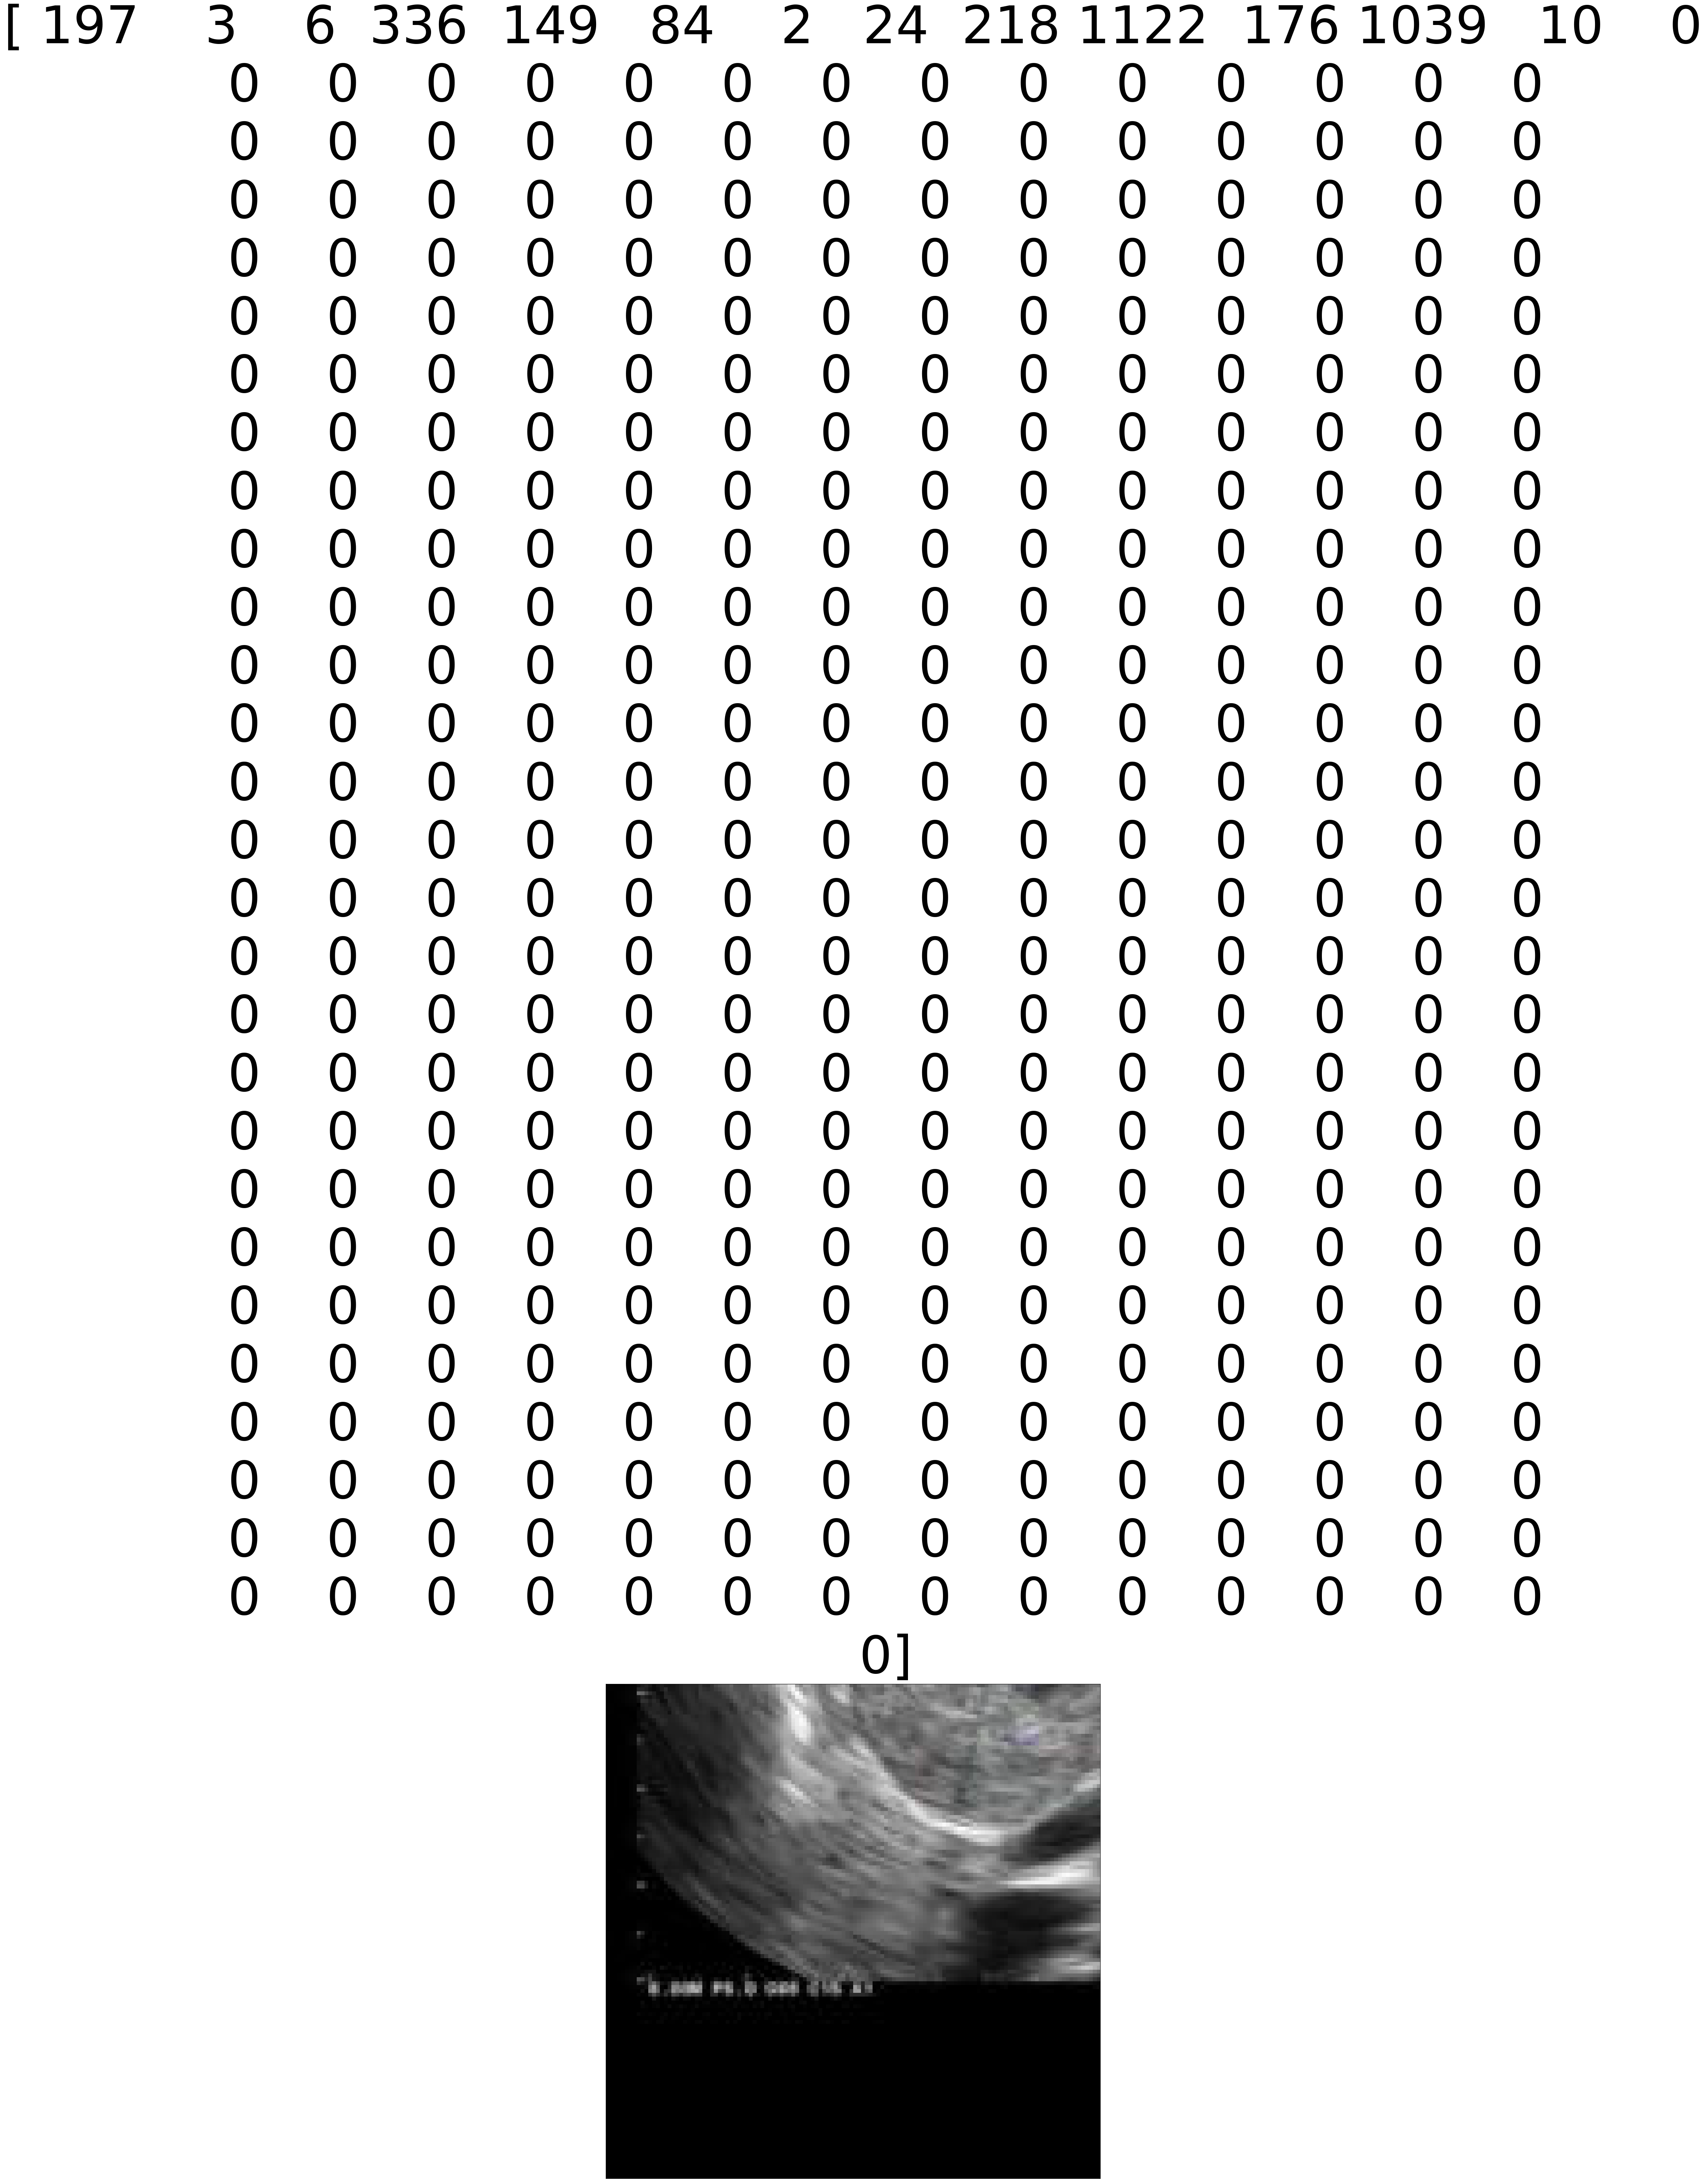

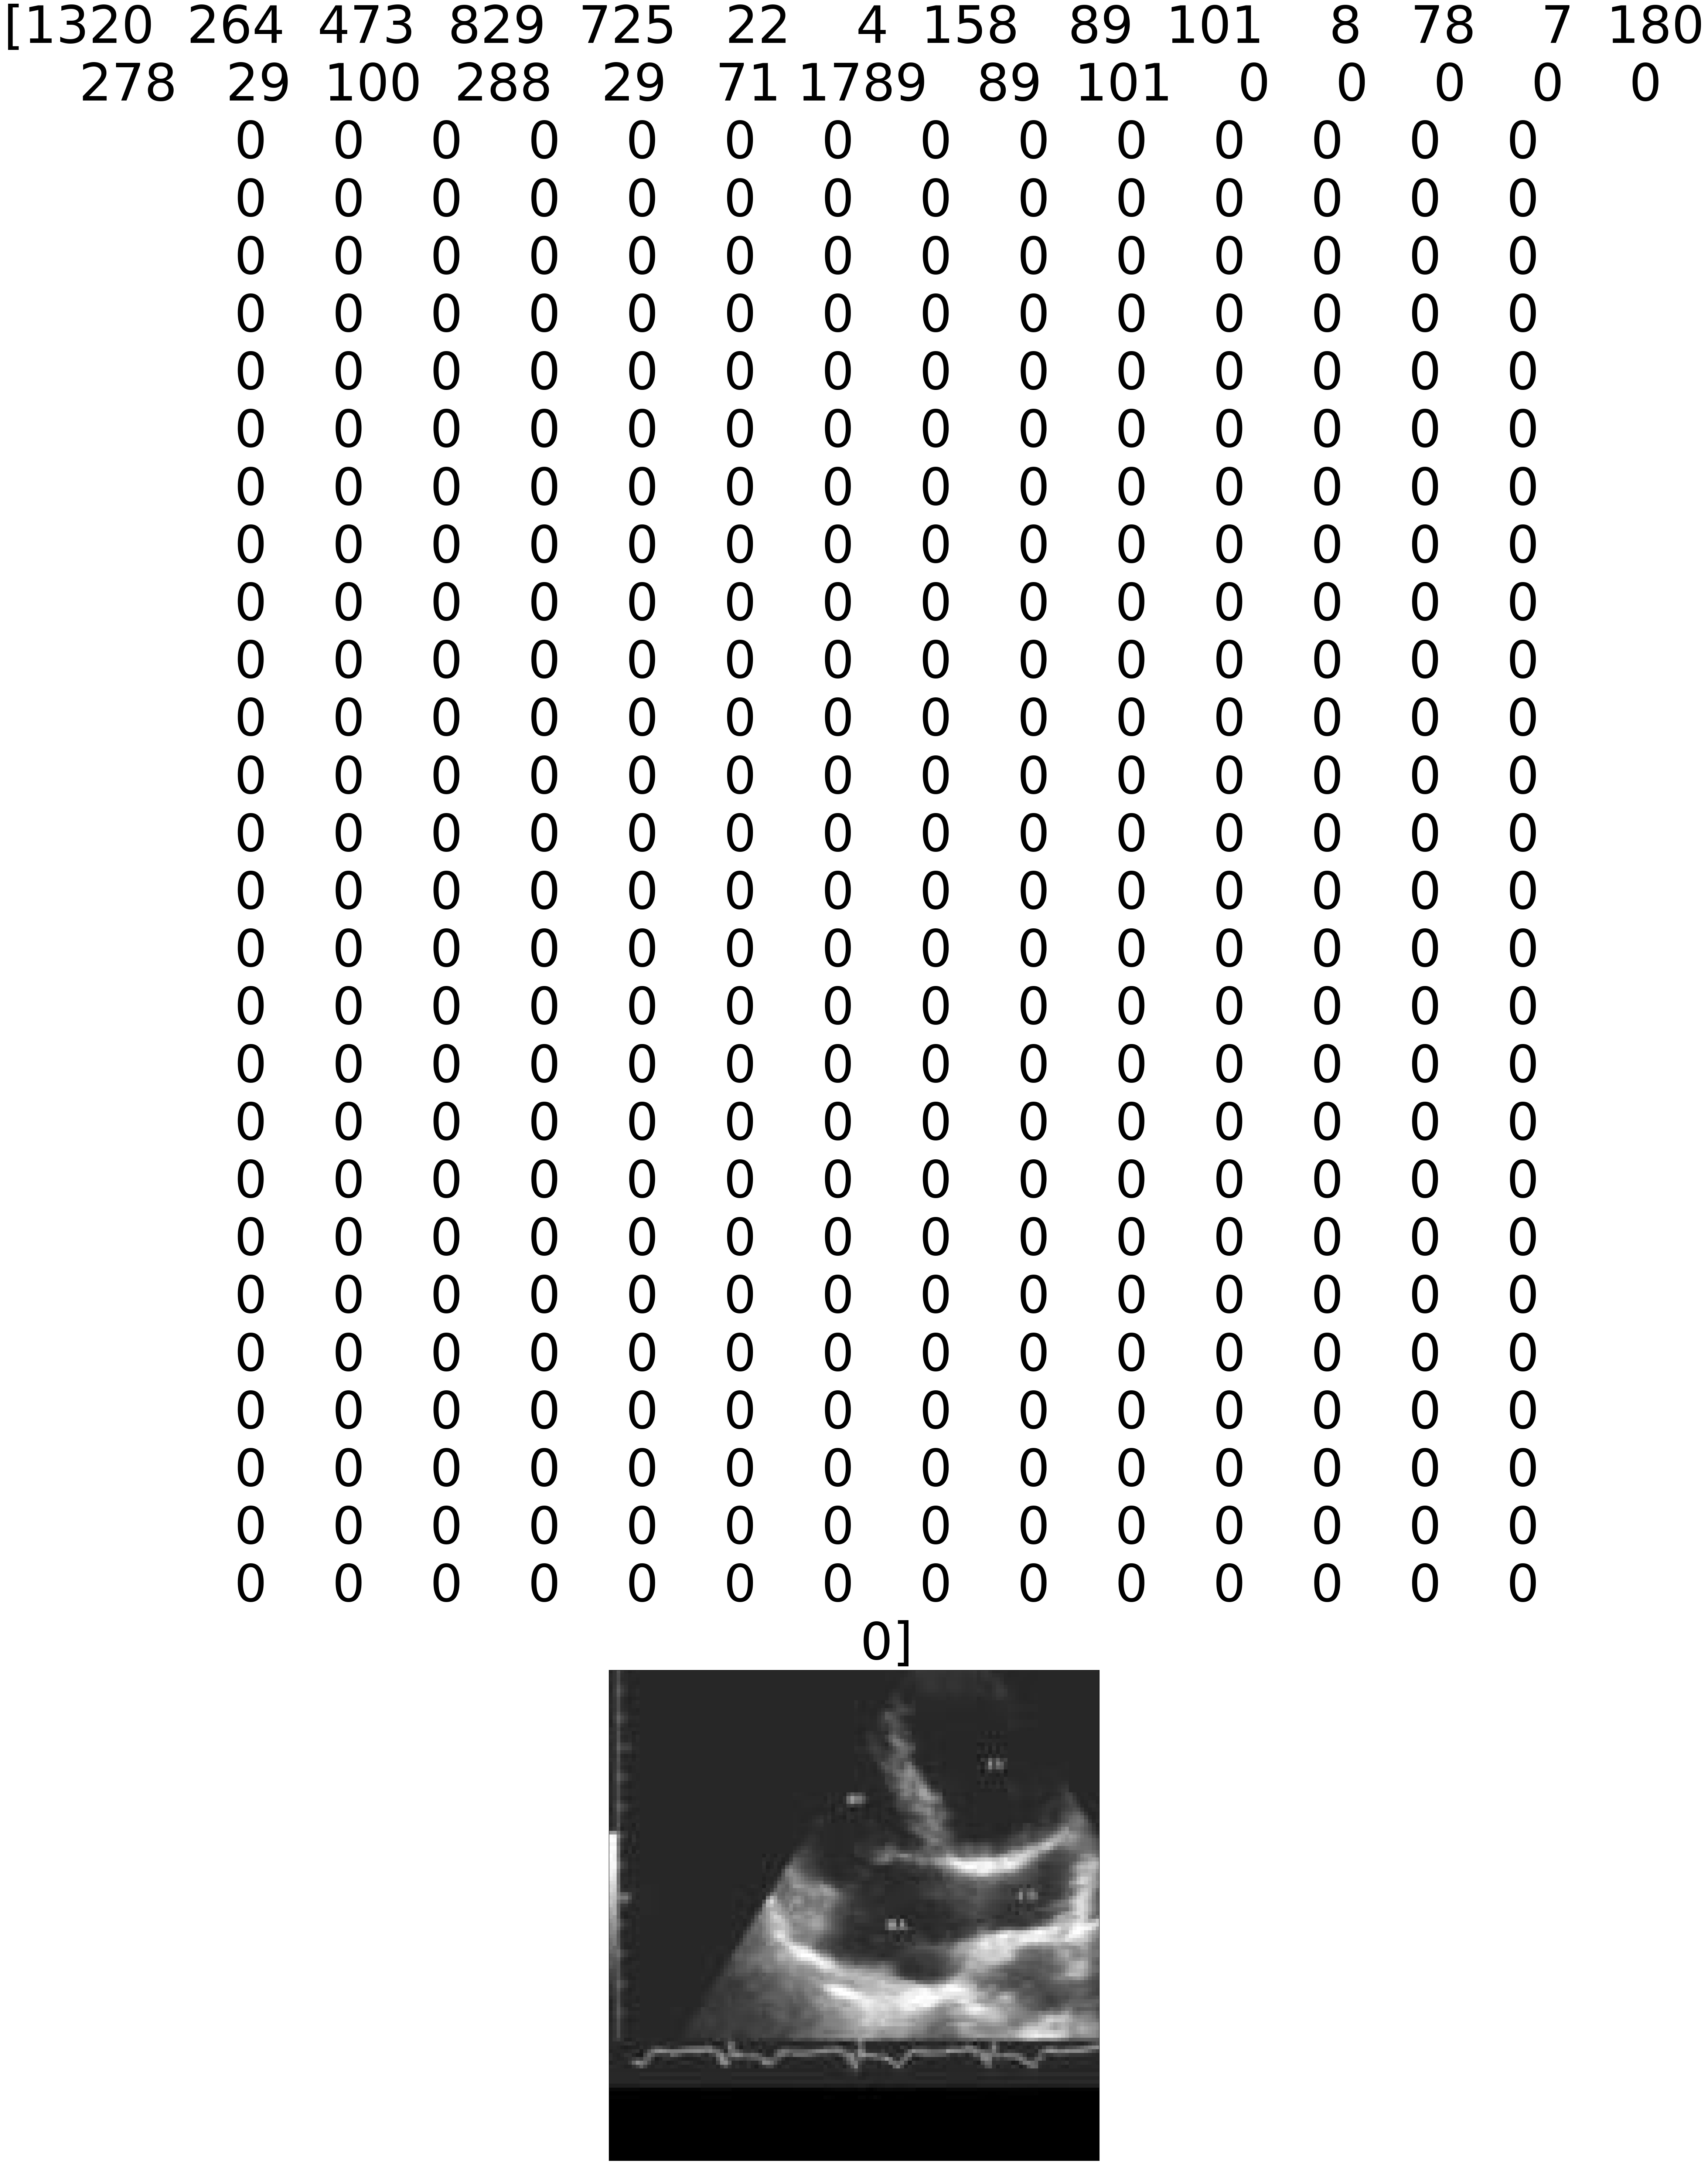

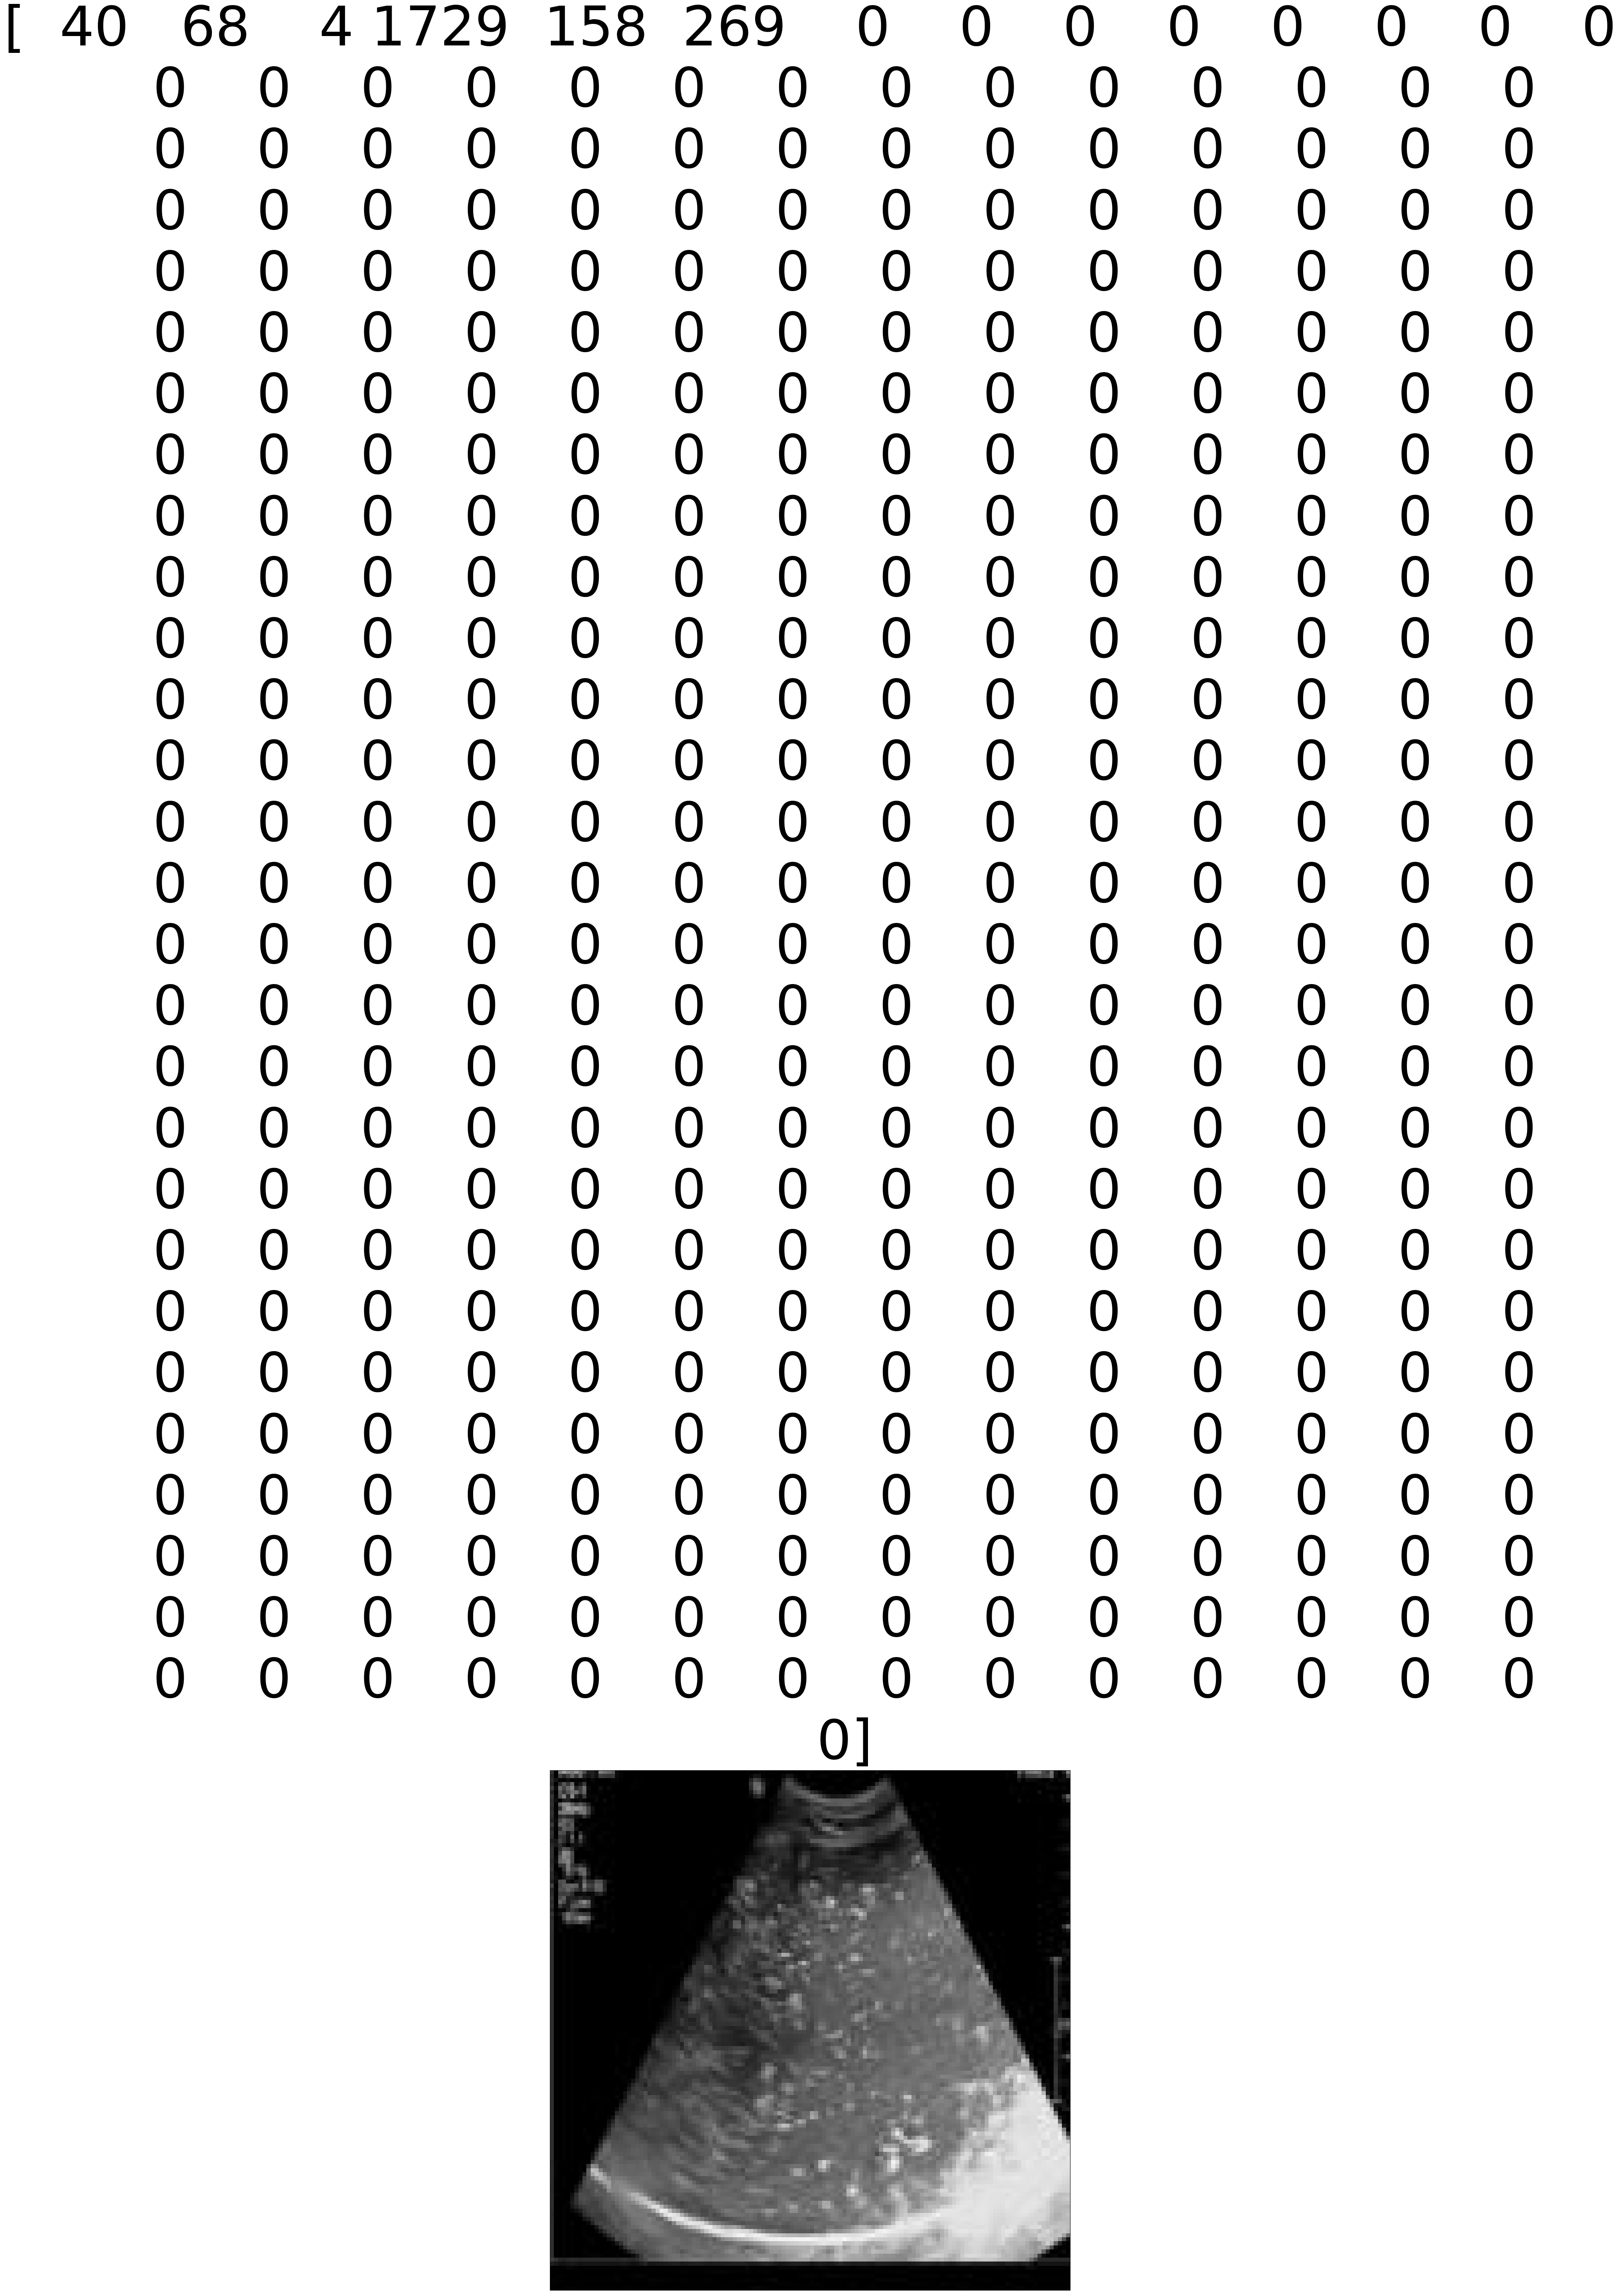

In [10]:
visualize_dataset(ds_train, 5)

In [11]:
def CNN_embedding(input_shape, latent_dim, embed_dim, seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='img_input_layer')
    x = tfkl.ZeroPadding2D((2,2))(input_layer)

    x = tfkl.Conv2D(64, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2D(128, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Conv2D(256, 3, padding='same', strides=2)(x)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.ReLU()(x)

    x = tfkl.Flatten()(x)
    x = tfkl.Dense(latent_dim, activation='relu')(x)
    x = tfkl.Dense(embed_dim, name='img_embedding_output_layer')(x)

    # Connect input and output through the Model class
    cnn_encoder = tfk.Model(inputs=input_layer, outputs=x, name='image_encoder')

    # Return the discriminator
    return cnn_encoder

In [12]:
class TokenAndPositionEmbedding(tfkl.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        # Embedding layer for the token
        self.token_emb = tfkl.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        # Embedding layer for the position
        self.pos_emb = tfkl.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        # Find the maximum length of the input
        maxlen = tf.shape(x)[-1]
        # Create a tensor with positions from 0 to maxlen-1
        positions = tf.range(start=0, limit=maxlen, delta=1)
        # Embed the positions
        positions = self.pos_emb(positions)
        # Embed the tokens
        x = self.token_emb(x)
        # Add the token and position embeddings
        return x + positions

In [13]:
class TransformerEncoderBlock(tfkl.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, **kwargs):
        super().__init__(**kwargs)
        self.att = tfkl.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tfk.Sequential(
            [
                tfkl.Dense(ff_dim, activation="relu"), 
                tfkl.Dense(embed_dim)
            ]
        )
        self.layernorm1 = tfkl.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tfkl.LayerNormalization(epsilon=1e-6)
        self.dropout1 = tfkl.Dropout(rate)
        self.dropout2 = tfkl.Dropout(rate)
        
    def call(self, inputs, training):
        # Self-attention
        attn_output = self.att(inputs, inputs)
        # Apply dropout to the attention output
        attn_output = self.dropout1(attn_output, training=training)
        # Add the attention output to the input and normalize
        out1 = self.layernorm1(inputs + attn_output)
        # Feed-forward
        ffn_output = self.ffn(out1)
        # Apply dropout to the feed-forward output
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add the feed-forward output to the previous output and normalize
        return self.layernorm2(out1 + ffn_output)

In [14]:
def text_embedding(sequence_lenght, vocab_size, num_heads, embed_dim, latent_dim):
    
    input_layer = tfk.Input(shape=(None,), dtype="int64", name="text_inputs")
    x = TokenAndPositionEmbedding(sequence_lenght, vocab_size, embed_dim)(input_layer)
    x = TransformerEncoderBlock(embed_dim, num_heads, latent_dim)(x)
    
    text_encoder = tfk.Model(input_layer, x)
    
    return text_encoder

In [15]:
def CLIP_loss(_, logits):
    #labels = np.arange(logits.shape[0])
    labels = np.arange(60, dtype=np.float32)
    
    loss_img = tfk.losses.sparse_categorical_crossentropy(labels, logits)
    loss_txt = tfk.losses.sparse_categorical_crossentropy(labels, kb.transpose(logits))
    
    return (loss_img + loss_txt)/2

In [16]:
def build_clip(img_input_shape=(128,128,3),
               txt_input_shape=(None, ), 
               latent_dim=1024, 
               embed_dim=128, 
               seq_lenght=393, 
               vocab_size=35491, 
               num_heads=4,
               temp=0.07):
    
    img_input = tfk.Input(shape=img_input_shape)
    txt_input = tfk.Input(shape=txt_input_shape)
    
    img_embed = CNN_embedding(img_input_shape, latent_dim, embed_dim, seed=42)(img_input)
    txt_embed = text_embedding(seq_lenght, vocab_size, num_heads, embed_dim, latent_dim)(txt_input)
    
    txt_embed = tfkl.Reshape((50304,))(txt_embed)
    txt_embed = tfkl.Dense(embed_dim)(txt_embed)
    
    img_norm = tfkl.Lambda(lambda x: kb.l2_normalize(x, axis=1))(img_embed)
    txt_norm = tfkl.Lambda(lambda x: kb.l2_normalize(x, axis=1))(txt_embed)
    
    logits = tfkl.Lambda(lambda x: kb.dot(x[0], kb.transpose(x[1])) * kb.exp(temp))((img_norm, txt_norm))
    
    clip = tfk.Model(inputs=[img_input, txt_input], outputs=logits)
    return clip

In [17]:
ds_train

[(array([[[1.        , 1.        , 0.9882353 ],
          [1.        , 1.        , 0.9882353 ],
          [1.        , 0.99607843, 0.99215686],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
  
         [[1.        , 1.        , 0.9882353 ],
          [1.        , 1.        , 0.99607843],
          [1.        , 1.        , 0.99607843],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
  
         [[0.7411765 , 0.73333335, 0.7294118 ],
          [0.7411765 , 0.73333335, 0.7294118 ],
          [0.7372549 , 0.7294118 , 0.7294118 ],
          ...,
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ],
          [0.        , 0.        , 0.        ]],
  
         ...,
  
         [[0.09019608, 0.08235294, 0.16862746],
          [0.0

In [18]:
model = build_clip()
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 model (Functional)             (None, None, 128)    5120768     ['input_2[0][0]']                
                                                                                                  
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 reshape (Reshape)              (None, 50304)        0           ['model[0][0]']            

In [19]:
tfk.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [20]:
model.compile(
    loss = CLIP_loss,
    #optimizer = tfk.optimizer.Adam(),
    metrics = ['mse', 'mae']
)

In [21]:
ds_train_i = [tf.convert_to_tensor(e[0]) for e in ds_train]
ds_train_t = [tf.convert_to_tensor(e[1]) for e in ds_train]

ds_val_i = [tf.convert_to_tensor(e[0]) for e in ds_val]
ds_val_t = [tf.convert_to_tensor(e[1]) for e in ds_val]

ds_train_i = tf.convert_to_tensor(ds_train_i)
ds_train_t = tf.convert_to_tensor(ds_train_t)
ds_val_i = tf.convert_to_tensor(ds_val_i)
ds_val_t = tf.convert_to_tensor(ds_val_t)
    

In [38]:
model.fit(
    x = [ds_train_i, ds_train_t],
    y = np.zeros((60, 60)),
    validation_data=([ds_val_i, ds_val_t], np.zeros((20))),
    batch_size = 32,
    #callbacks = [
    #    tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5, restore_best_weights=True)
    #]
)

InvalidArgumentError: Graph execution error:

Detected at node 'model_1/reshape/Reshape' defined at (most recent call last):
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2940, in run_cell
      result = self._run_cell(
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2995, in _run_cell
      return runner(coro)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3194, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3373, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3433, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_10385/1825046375.py", line 1, in <module>
      model.fit(
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/riga/anaconda3/envs/tf-gpu/lib/python3.10/site-packages/keras/layers/reshaping/reshape.py", line 137, in call
      result = tf.reshape(inputs, (tf.shape(inputs)[0],) + self.target_shape)
Node: 'model_1/reshape/Reshape'
Input to reshape is a tensor with 1609728 values, but the requested shape has 3018240
	 [[{{node model_1/reshape/Reshape}}]] [Op:__inference_train_function_18016]